# Neural Network Using All Available Data

## Imports

In [41]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preprocess

In [25]:
data = pd.read_csv('data/clean_data.csv')

In [ ]:
# Store IDs separately
ids = data['ID'].values

# Remove ID and target (efs/efs_time) from features
X = data.drop(['ID', 'efs', 'efs_time'], axis=1)
y = data['efs'].values

# Split data into train, validation, and test sets
# First split: separate test set (10%)
X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(
    X, y, ids, test_size=0.1, random_state=42
)

# Second split: get validation set from remaining data (20%)
val_size_adjusted = 0.2 / (1 - 0.1)
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X_temp, y_temp, ids_temp, test_size=val_size_adjusted, random_state=42
)

print(f"Original: {data.shape[0]}")
print(f"Training: {X_train.shape[0]} ({len(X_train)/len(data):.1%})")
print(f"Validation: {X_val.shape[0]} ({len(X_val)/len(data):.1%})")
print(f"Testing: {X_test.shape[0]} ({len(X_test)/len(data):.1%})")

Original: 28800
Training: 20160 (70.0%)
Validation: 5760 (20.0%)
Testing: 2880 (10.0%)


In [26]:
# Standardize features (For fitting into tensor)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test)

X_train_tensor.shape

torch.Size([20160, 58])

## Simple Model

In [18]:
# Define a simple neural network with fully connected layers
class SimpleEFSModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleEFSModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

## Train Model

In [35]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

The training and validation done below are a proof-of-concept for a simple binary classification model predicting EFS

In [44]:
 # Initialize model
input_size = X_train.shape[1]
model = SimpleEFSModel(input_size)

# Define hyper-parameters
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

Epoch 1/20, Train Loss: 0.2337, Val Loss: 0.0624
Epoch 2/20, Train Loss: 0.0705, Val Loss: 0.0537
Epoch 3/20, Train Loss: 0.0539, Val Loss: 0.0475
Epoch 4/20, Train Loss: 0.0467, Val Loss: 0.0501
Epoch 5/20, Train Loss: 0.0433, Val Loss: 0.0438
Epoch 6/20, Train Loss: 0.0366, Val Loss: 0.0458
Epoch 7/20, Train Loss: 0.0345, Val Loss: 0.0445
Epoch 8/20, Train Loss: 0.0338, Val Loss: 0.0470
Epoch 9/20, Train Loss: 0.0344, Val Loss: 0.0466
Epoch 10/20, Train Loss: 0.0306, Val Loss: 0.0468
Epoch 11/20, Train Loss: 0.0287, Val Loss: 0.0518
Epoch 12/20, Train Loss: 0.0282, Val Loss: 0.0447
Epoch 13/20, Train Loss: 0.0261, Val Loss: 0.0488
Epoch 14/20, Train Loss: 0.0263, Val Loss: 0.0455
Epoch 15/20, Train Loss: 0.0250, Val Loss: 0.0465
Epoch 16/20, Train Loss: 0.0243, Val Loss: 0.0488
Epoch 17/20, Train Loss: 0.0230, Val Loss: 0.0470
Epoch 18/20, Train Loss: 0.0204, Val Loss: 0.0569
Epoch 19/20, Train Loss: 0.0209, Val Loss: 0.0502
Epoch 20/20, Train Loss: 0.0203, Val Loss: 0.0502


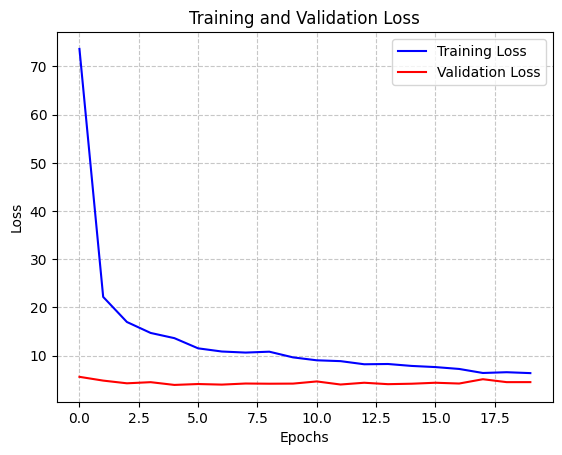

In [45]:
# Training loop
train_losses = []
val_losses = []

for epoch in range(epochs):

    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss)
    
    # Display epoch losses
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')
    # Display epoch accuracies as percentages (personal preference)
    # print(f'Epoch {epoch+1}/{epochs}, Train Loss: {1-(running_loss/len(train_loader))*100:.2f}, Val Loss: {(1-val_loss/len(val_loader))*100:.2f}')

# Plot training loop results
plt.plot(range(epochs), train_losses, 'b-', label='Training Loss')
plt.plot(range(epochs), val_losses, 'r-', label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()